# Spectral Analyses of SickKids Dataset

Here, we are interested in parsing two questions:

1. what is the effect of anesthetic on subjects? 
    - Can we answer this using data from their ``extraoperative`` monitoring compared with ``preresection`` sessions? Is it then consistent after resection?
    
2. what does the spectrum of sEEG vs ECoG look like?
    - Some subjects have varying signal behavior in the depth vs grid electrodes.
    
We can explore these questions using two means:
1. spectral analysis using wavelet/fft methods
2. Dynamic mode decomposition and analysis of the eigenspectrum of the spatial DMD modes of the data.

FFT:

$$x(t) = \sum_{n} a_n e^{int}$$
    
where we will represent the data in windows of the $a_n$ term, which are the Fourier coefficients of the frequency.

DMD:

$$X(t+1) = AX(t)$$
    
and we will run the DMD procedure to get the DMD modes such that: $X(t+1) = \sum_k \psi_k \lambda_k X(t)$$

In [1]:
import numpy as np
import pandas as pd
import mne
import os
import json
import os.path as op
from pathlib import Path
import collections

from sklearn.datasets import make_spd_matrix
from mne.io import RawArray
from mne import create_info
from mne_bids import BIDSPath, get_entity_vals, read_raw_bids
import mne
mne.utils.use_log_level('error')
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.cm as cm

import pydmd

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, explained_variance_score

from mne_features.univariate import compute_spect_slope
from mne_features.utils import power_spectrum

from eztrack.io.base import _add_desc_to_bids_fname
from eztrack.io import read_derivative_npy
from eztrack.fragility import (lds_raw_fragility, DiscreteLinearSystem, 
                               SystemIDModel, StructuredPerturbationModel)
from eztrack.viz import _load_turbo, generate_heatmap
from eztrack.posthoc.hypo import compute_null

import sys
sys.path.append('../../')
from sickkids.dmd.dmd import rescale_modes
from sickkids.posthoc.spectral import compute_significant_freqs, compute_bootstrap_lr

_load_turbo()

%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
sns.set_context('paper')

In [3]:
def compute_frequencies(eigs, delta_t):
    """Compute frequencies of eigenvalues.
    
    delta_t : float
        The number of seconds between each sample (1 / sfreq).
    """
    freqs = []
    growth_rates = []

    for idx, eig in enumerate(eigs):
        if eig == 0:
            print(f'Found zero eigenvalue {eig} at {idx} index.')
            freqs.append(np.nan)
            growth_rates.append(np.nan)
            continue
#         if np.conj(eig) in memo:
#             continue
#         memo[eig] = 1
        mode = np.log(eig) / delta_t
        
        freqs.append(np.imag(mode) / (2*np.pi))
        growth_rates.append(np.real(mode))
    return growth_rates, freqs

In [4]:
def make_plot(X, x=None, y=None, figsize=(12, 8), title=''):
    """
    Plot of the data X
    """
    plt.figure(figsize=figsize)
    plt.title(title)
    X = np.real(X)
    print(x.shape, y.shape, X.shape)
    CS = plt.pcolor(x, y, X)
    cbar = plt.colorbar(CS)
    plt.xlabel('Space')
    plt.ylabel('Time')
    plt.show()

# Configure Paths and BIDS related metadata

In [5]:
# load in originally ran npy data
root = Path('/Users/adam2392/OneDrive - Johns Hopkins/sickkids/')
# root = Path('/Users/adam2392/Dropbox/epilepsy_bids/')
deriv_root = root / 'derivatives'
reference = 'monopolar'
deriv_chain = Path('originalsampling') / 'radius1.5' / 'fragility' / reference

sessions = ['extraoperative', 'preresection', 
            'intraresection', 'postresection']
desc = 'perturbmatrix'

In [6]:
subject = 'E1'
session = 'extraoperative'
acquisition = 'ecog'
run = '01'
datatype = 'ieeg'
extension = '.vhdr'

# subject = 'pt1'
# session = 'presurgery'
# acquisition = 'ecog'
# run = '01'

In [7]:
subjects = get_entity_vals(root, 'subject')
ignore_subjects = [sub for sub in subjects if sub != subject]

sessions = get_entity_vals(root, 'session', ignore_subjects=ignore_subjects)
ignore_sessions = [ses for ses in sessions if ses != session]

tasks = get_entity_vals(root, 'task', 
                        ignore_subjects=ignore_subjects,
                        ignore_sessions=ignore_sessions
                       )

task = tasks[0]
print(tasks)
print(task)

['ictal', 'interictalasleep', 'interictalawake']
ictal


In [8]:
bids_path = BIDSPath(subject=subject, session=session,task=task,
                    acquisition=acquisition, run=run, suffix=datatype,
                    datatype=datatype, extension=extension,
                    root=root)
print(bids_path)

/Users/adam2392/OneDrive - Johns Hopkins/sickkids/sub-E1/ses-extraoperative/ieeg/sub-E1_ses-extraoperative_task-ictal_acq-ecog_run-01_ieeg.vhdr


# Load raw data

In [11]:
raw = read_raw_bids(bids_path, verbose=False)

print(raw)

<RawBrainVision | sub-E1_ses-extraoperative_task-ictal_acq-ecog_run-01_ieeg.eeg, 148 x 343040 (167.4 s), ~195 kB, data not loaded>


<ipython-input-11-93eddeff2657>:1: RuntimeWarning: Did not find any events.tsv associated with sub-E1_ses-extraoperative_task-ictal_acq-ecog_run-01.

The search_str was "/Users/adam2392/OneDrive - Johns Hopkins/sickkids/sub-E1/**/sub-E1_ses-extraoperative*events.tsv"
  raw = read_raw_bids(bids_path, verbose=False)
<ipython-input-11-93eddeff2657>:1: RuntimeWarning: There are channels without locations (n/a) that are not marked as bad: ['C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8', 'C9', 'C10', 'C11', 'C12', 'C13', 'C14', 'C16', 'C17', 'C18', 'C19', 'C20', 'C21', 'C22', 'C23', 'C24', 'C25', 'C26', 'C27', 'C28', 'C29', 'C30', 'C31', 'C32', 'C33', 'C34', 'C35', 'C36', 'C37', 'C38', 'C39', 'C40', 'C41', 'C42', 'C43', 'C44', 'C45', 'C46', 'C47', 'C48', 'C49', 'C50', 'C51', 'C52', 'C53', 'C54', 'C55', 'C56', 'C58', 'C59', 'C60', 'C61', 'C62', 'C63', 'C64', 'IPD1', 'IPD2', 'IPD3', 'IPD4', 'IPD5', 'IPD6', 'IAD1', 'IAD2', 'IAD3', 'IAD4', 'IAD5', 'IAD6', 'SAD1', 'SAD2', 'SAD3', 'SAD4', 'SAD5', 

In [12]:
raw.drop_channels(raw.info['bads'])
raw.pick_types(seeg=True, ecog=True)
raw.load_data()
print(raw)

l_freq = 0.5
h_freq = 300
line_freq = raw.info['line_freq']
nyq_freq = raw.info['sfreq'] // 2
freqs = np.arange(line_freq, min(h_freq, nyq_freq), line_freq)
raw.filter(l_freq=l_freq, h_freq=h_freq)

print(f'Band pass filtering between {l_freq} and {h_freq}')
print(f'Notch filtering at {freqs}')

raw = raw.notch_filter(freqs, method='fir')

<RawBrainVision | sub-E1_ses-extraoperative_task-ictal_acq-ecog_run-01_ieeg.eeg, 98 x 343040 (167.4 s), ~256.6 MB, data loaded>
Band pass filtering between 0.5 and 300
Notch filtering at [ 60 120 180 240]


# Try out normalizations of the data

Note that in SickKids data and probably other datasets, there is a marked difference in spectral content distribution when looking at sEEG electrodes vs ECoG electrodes. This is in part due to the impedances, as well as other factors.

In [12]:
from sklearn.preprocessing import MinMaxScaler

-8.11605811478161e-06 -4.309251706176873e-05
0.0005689575177793163
0.00011219211806751127


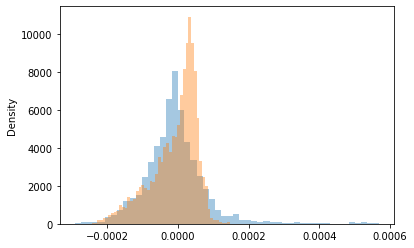

In [15]:
fig, ax = plt.subplots()
seeg_raw = raw.copy().pick_types(seeg=True)
ecog_raw = raw.copy().pick_types(ecog=True)
seeg_data = seeg_raw.get_data(start=0, stop=500)
ecog_data = ecog_raw.get_data(start=0, stop=500)

eegwin = raw.get_data(start=0, stop=500)

# rescale the data independently
scaler = MinMaxScaler()
# ecog_data = scaler.fit_transform(ecog_data.T).T
# seeg_data = scaler.fit_transform(seeg_data.T).T

# ecog_data = (ecog_data - eegwin.min()) / (eegwin.max() - eegwin.min())
# seeg_data = (seeg_data - eegwin.min()) / (eegwin.max() - eegwin.min())

sns.distplot(ecog_data.flatten(), label='seeg', ax=ax)
sns.distplot(seeg_data.flatten() + (ecog_data.mean() - seeg_data.mean()), label='ecog', ax=ax)

print(ecog_data.mean(), seeg_data.mean())
print(ecog_data.flatten().max())
print(seeg_data.flatten().max())

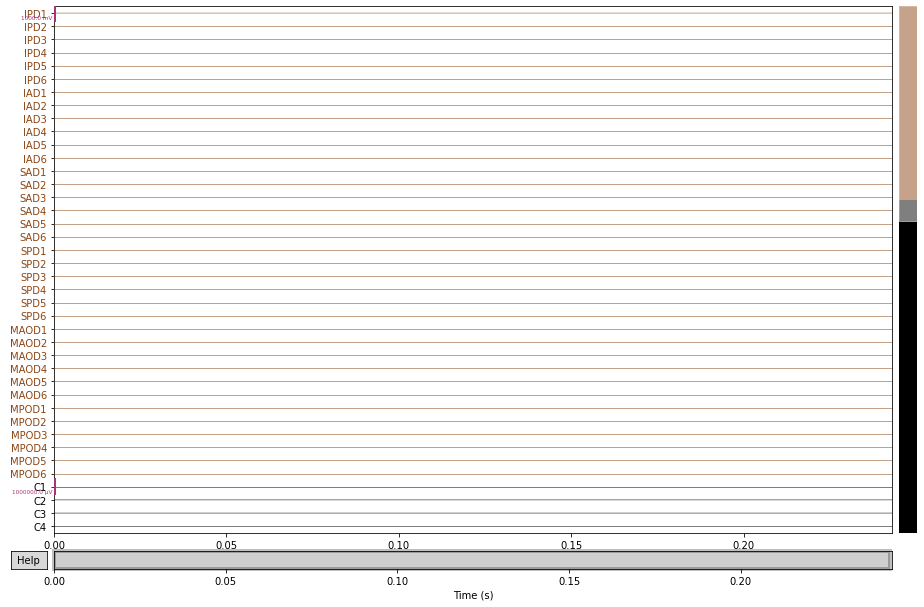

2578.82033351041


In [16]:
ch_names = seeg_raw.ch_names + ecog_raw.ch_names
ch_types = ['seeg']*len(seeg_raw.ch_names) + ['ecog'] * len(ecog_raw.ch_names)
info = create_info(ch_names=ch_names, ch_types=ch_types, sfreq=raw.info['sfreq'])
rawarr = RawArray(np.concatenate((seeg_data, ecog_data)), info)

rawarr.plot(scalings={'ecog': 0.5, 'seeg': 0.5}, n_channels=40)
print(np.linalg.cond(rawarr.get_data()))

<ipython-input-94-b2431a69ea22>:1: RuntimeWarning: Channel locations not available. Disabling spatial colors.
  raw.plot_psd(average=False, fmin=l_freq, fmax=h_freq)


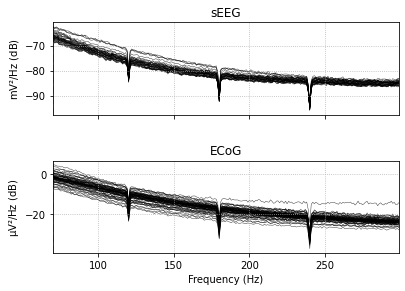

PSD


In [94]:
raw.plot_psd(average=False, fmin=l_freq, fmax=h_freq)
print('PSD')

# TFR Analysis of SickKids Data

Use mne-python's wavelet transform analysis to convert data into TFR.

In [194]:
# generate events to make epochs
events = make_fixed_length_events(raw, id=1, 
#                                   start=0, stop=None,
                                  duration=2.0, overlap=1.0)
epochs = Epochs(raw, events, event_id=1, baseline=None,
               tmin=0, tmax=2.0)

print(epochs)
print(epochs.get_data().shape)

<Epochs |  300 events (good & bad), 0 - 1.99982 sec, baseline off, ~142 kB, data not loaded,
 '1': 300>
(300, 98, 4099)


In [206]:
from mne import make_fixed_length_events, Epochs
from mne.time_frequency import AverageTFR

In [208]:
rawdata = raw.get_data(start=0, stop=100000)
print(rawdata.shape)

(98, 100000)


In [201]:
freqs = np.logspace(7, 1, base=2, num=50)[::-1]
print(freqs)

[  2.           2.17716233   2.37001791   2.57995685   2.80849244
   3.05727197   3.32808868   3.62289466   3.94381489   4.2931626
   4.67345595   5.08743612   5.53808714   6.02865736   6.56268285
   7.14401294   7.77683793   8.4657193    9.21562258  10.03195316
  10.92059526  11.88795431  12.94100316  14.0873323   15.3352046
  16.6936149   18.17235475  19.78208311  21.53440308  23.4419456
  25.51846045  27.77891541  30.23960411  32.91826347  35.8342016
  39.00843693  42.46384973  46.22534701  50.32004211  54.77745007
  59.62970042  64.91176877  70.66172888  76.92102715  83.73478136
  91.15210586  99.2264656  108.01606154 117.58425012 128.        ]


In [209]:
# compute wavelet transform
power_arr = mne.time_frequency.tfr_array_morlet(rawdata[np.newaxis, ...],
                                           sfreq=raw.info['sfreq'], freqs=freqs, n_cycles=3.0,
                                           output='power', n_jobs=-1)

[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  10 tasks      | elapsed:    5.3s
[Parallel(n_jobs=8)]: Done  64 tasks      | elapsed:   24.6s
[Parallel(n_jobs=8)]: Done  98 out of  98 | elapsed:   35.8s finished


In [214]:
power = AverageTFR(raw.info, data=power_arr.squeeze(), times=raw.times[:100000], freqs=freqs, nave=0,
                  comment=bids_path.task, 
                  method='morlet wavelet')

print(power)

NameError: name 'power' is not defined

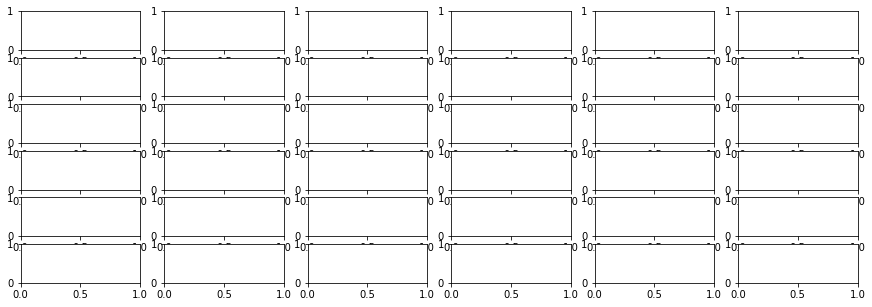

In [19]:
fig, axes = plt.subplots(6, 6, figsize=(15,5))

for idx, ax in enumerate(axes.flat):
    ch_name = power.ch_names[idx]
fig = power.plot(picks=[ch_name], dB=True, 
#                      axes=ax,
                 title=ch_name, show=False,
                tmin=0, tmax=5.0)
plt.show()

## Multitaper FFT analysis

In [232]:
freqs = np.linspace(1, 300, 50)
print(freqs)

[  1.           7.10204082  13.20408163  19.30612245  25.40816327
  31.51020408  37.6122449   43.71428571  49.81632653  55.91836735
  62.02040816  68.12244898  74.2244898   80.32653061  86.42857143
  92.53061224  98.63265306 104.73469388 110.83673469 116.93877551
 123.04081633 129.14285714 135.24489796 141.34693878 147.44897959
 153.55102041 159.65306122 165.75510204 171.85714286 177.95918367
 184.06122449 190.16326531 196.26530612 202.36734694 208.46938776
 214.57142857 220.67346939 226.7755102  232.87755102 238.97959184
 245.08163265 251.18367347 257.28571429 263.3877551  269.48979592
 275.59183673 281.69387755 287.79591837 293.89795918 300.        ]


In [244]:
# compute wavelet transform
# power_arr = mne.time_frequency.tfr_array_multitaper(rawdata[np.newaxis, ...],
#                                            sfreq=raw.info['sfreq'], freqs=freqs, n_cycles=3.0,
#                                            output='power', n_jobs=-1)
print(rawdata.shape)
power_arr, freqs = mne.time_frequency.psd_array_welch(rawdata, sfreq=raw.info['sfreq'], 
                                                fmin=2, fmax=300, average=None,
#                                                       n_per_seg=0,,
#                                                 n_overlap=1,
                                                n_jobs=2)
print(power_arr.shape, freqs.shape)

(98, 100000)


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.


(98, 37, 390) (37,)


[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:    2.0s remaining:    0.0s
[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:    2.0s finished


In [ ]:
power = AverageTFR(raw.info, data=power_arr.squeeze(), times=raw.times[:100000], freqs=freqs, nave=0,
                  comment=bids_path.task, 
                  method='multitaper FFT')

print(power)

<RawBrainVision | sub-E1_ses-extraoperative_task-ExtraoperativeInterictalAwakeD1_acq-ecog_run-01_ieeg.eeg, 98 x 618112 (301.6 s), ~142 kB, data not loaded>
(98, 62, 40) (62,)


<AxesSubplot:>

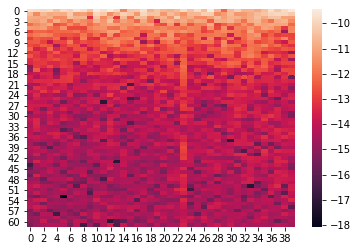

In [59]:
fmin = 1
fmax = 500
winsize = 2500

psds, freqs = mne.time_frequency.psd_welch(raw, fmin=fmin, fmax=fmax, 
                                           tmin=5, tmax=10, 
#                                            n_fft=winsize,
                                           n_per_seg=winsize, 
#                                            n_overlap=winsize, 
                                           average=None)

print(raw)
print(psds.shape, freqs.shape)

fig, ax = plt.subplots()

sns.heatmap(np.log10(psds[0,...]), ax=ax)

In [53]:
fmin = 1
fmax = 500
winsize = 2.5

psds, freqs = mne.time_frequency.psd_multitaper(raw, fmin=fmin, fmax=fmax, 
                                           tmin=5, tmax=10)

print(raw)
print(psds.shape, freqs.shape)

<RawBrainVision | sub-E1_ses-extraoperative_task-ExtraoperativeInterictalAwakeD1_acq-ecog_run-01_ieeg.eeg, 98 x 618112 (301.6 s), ~142 kB, data not loaded>
(98, 2495) (2495,)


# DMD on Anesthesia and Non-Anesthesia

Let us use DMD and its variants as a method for analyzing the dynamics of the iEEG data during interictal-asleep and anesthesia pre-resection. This will give us a sense of how the dynamics during each session are different, and what are the possible effects of anesthesia.

In [13]:
# make bids path for a certain subject
subject = 'E1'
session = 'extraoperative'
bids_path = BIDSPath(subject=subject, session=session,task=task,
                    acquisition=acquisition, run=run, suffix=datatype,
                    datatype=datatype, extension=extension,
                    root=root)
print(bids_path)

/Users/adam2392/OneDrive - Johns Hopkins/sickkids/sub-E1/ses-extraoperative/ieeg/sub-E1_ses-extraoperative_task-ictal_acq-ecog_run-01_ieeg.vhdr


## Estimate the PSD slope for this data

In [14]:
raw = read_raw_bids(bids_path, verbose=False)
raw.drop_channels(raw.info['bads'])
raw.pick_types(seeg=True, ecog=True)
raw.load_data()
print(raw)

l_freq = 0.5
h_freq = 500
line_freq = raw.info['line_freq']
nyq_freq = raw.info['sfreq'] // 2
freqs = np.arange(line_freq, min(h_freq, nyq_freq), line_freq)
raw.filter(l_freq=l_freq, h_freq=h_freq)

print(f'Band pass filtering between {l_freq} and {h_freq}')
print(f'Notch filtering at {freqs}')

raw = raw.notch_filter(freqs, method='fir')

<ipython-input-14-7e229e121881>:1: RuntimeWarning: Did not find any events.tsv associated with sub-E1_ses-extraoperative_task-ictal_acq-ecog_run-01.

The search_str was "/Users/adam2392/OneDrive - Johns Hopkins/sickkids/sub-E1/**/sub-E1_ses-extraoperative*events.tsv"
  raw = read_raw_bids(bids_path, verbose=False)
<ipython-input-14-7e229e121881>:1: RuntimeWarning: There are channels without locations (n/a) that are not marked as bad: ['C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8', 'C9', 'C10', 'C11', 'C12', 'C13', 'C14', 'C16', 'C17', 'C18', 'C19', 'C20', 'C21', 'C22', 'C23', 'C24', 'C25', 'C26', 'C27', 'C28', 'C29', 'C30', 'C31', 'C32', 'C33', 'C34', 'C35', 'C36', 'C37', 'C38', 'C39', 'C40', 'C41', 'C42', 'C43', 'C44', 'C45', 'C46', 'C47', 'C48', 'C49', 'C50', 'C51', 'C52', 'C53', 'C54', 'C55', 'C56', 'C58', 'C59', 'C60', 'C61', 'C62', 'C63', 'C64', 'IPD1', 'IPD2', 'IPD3', 'IPD4', 'IPD5', 'IPD6', 'IAD1', 'IAD2', 'IAD3', 'IAD4', 'IAD5', 'IAD6', 'SAD1', 'SAD2', 'SAD3', 'SAD4', 'SAD5', 

<RawBrainVision | sub-E1_ses-extraoperative_task-ictal_acq-ecog_run-01_ieeg.eeg, 98 x 343040 (167.4 s), ~256.6 MB, data loaded>
Band pass filtering between 0.5 and 500
Notch filtering at [ 60 120 180 240 300 360 420 480]


In [15]:
sfreq = raw.info['sfreq']
data = raw.get_data()
print(data.shape)

(98, 343040)


In [16]:
output = compute_spect_slope(sfreq, data, fmin=1., fmax=300.)
output = output.reshape((len(raw.ch_names), 4))
print(output.shape)

(98, 4)


In [80]:
ch_names = raw.ch_names
for idx in range(len(raw.ch_names)):
    intercept, slope, _, _ = output[idx, :]
    print(f'The estimated slope of {ch_names[idx]} is a = %1.2f and the estimated intercept is '
      'b = %1.3e' % (slope, intercept))
    break

ecog_inds = mne.pick_types(raw.info, ecog=True)
seeg_inds = mne.pick_types(raw.info, seeg=True)

The estimated slope of C1 is a = -3.58 and the estimated intercept is b = -6.114e+00


Text(0.5, 0, '$R^2$ Value')

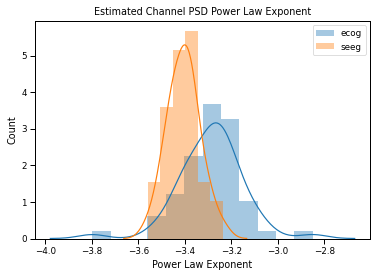

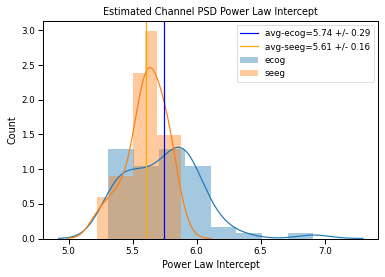

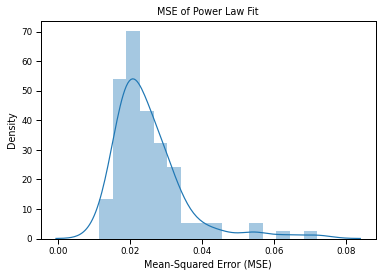

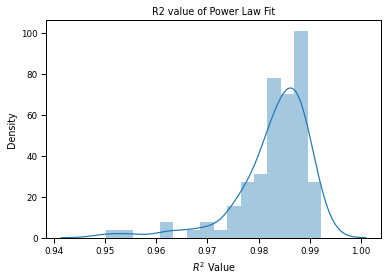

In [25]:
# get slopes per electrode modality
ecog_slopes = output[ecog_inds, 1]
seeg_slopes = output[seeg_inds, 1]

# plot distribution of slopes
fig, ax = plt.subplots()
sns.distplot(ecog_slopes, ax=ax, label='ecog')
sns.distplot(seeg_slopes, ax=ax, label='seeg')
ax.set(
    title='Estimated Channel PSD Power Law Exponent',
    xlabel='Power Law Exponent',
    ylabel='Count',
)
ax.legend()

# plot distribution of intercepts
ecog_intc = output[ecog_inds, 0]
seeg_intc = output[seeg_inds, 0]

fig, ax = plt.subplots()
sns.distplot(ecog_intc, ax=ax, label='ecog')
sns.distplot(seeg_intc, ax=ax, label='seeg')
ax.set(
    title='Estimated Channel PSD Power Law Intercept',
    xlabel='Power Law Intercept',
    ylabel='Count',
)
ax.axvline(np.mean(ecog_intc), label=f'avg-ecog={np.mean(ecog_intc):.2f} +/- {np.std(ecog_intc):.2f}', color='blue')
ax.axvline(np.mean(seeg_intc), label=f'avg-seeg={np.mean(seeg_intc):.2f} +/- {np.std(seeg_intc):.2f}', color='orange')
ax.legend()

plt.figure()
sns.distplot(output[:, 2])
plt.title('MSE of Power Law Fit')
plt.xlabel('Mean-Squared Error (MSE)')

plt.figure()
sns.distplot(output[:, 3])
plt.title('R2 value of Power Law Fit')
plt.xlabel('$R^2$ Value')

In [112]:
psd, freqs = power_spectrum(sfreq, data)
mask = np.logical_and(1 <= freqs, freqs <= 300)
psd, freqs = psd[0, mask], freqs[mask]

intercept, slope, _, _ = output[0, :]
print(psd.shape, freqs.shape)
print(intercept, slope)

(31,) (31,)
-6.11391537827926 -3.5812367929174207


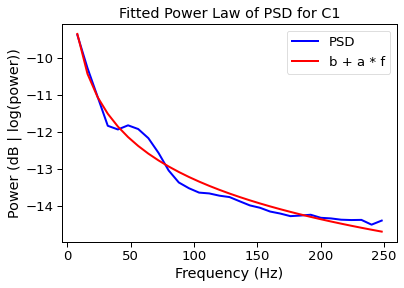

In [113]:
sns.set_context('paper', font_scale=1.5)
plt.figure()
plt.plot(freqs, np.log10(psd), '-b', lw=2, label='PSD')
plt.plot(freqs, intercept + slope * np.log10(freqs), '-r', lw=2, label='b + a * f')
plt.title(f'Fitted Power Law of PSD for {ch_names[0]}')
ax = plt.gca()
ax.set(xlabel='Frequency (Hz)', 
       ylabel='Power (dB | log(power))')
ax.legend()

In [114]:
# get all interecepts and slopes from existing data
intercepts = output[:, 0]
slopes = output[:, 1]

## Interictal Awake

In [17]:
print(bids_path.copy().update(task=None).match())
bids_path.update(session='extraoperative', task='interictalawake', run='01')
# bids_path.update(session='extraoperative', task='IED', run='02')

[BIDSPath(
root: /Users/adam2392/OneDrive - Johns Hopkins/sickkids
datatype: ieeg
basename: sub-E1_ses-extraoperative_task-ictal_acq-ecog_run-01_ieeg.vhdr), BIDSPath(
root: /Users/adam2392/OneDrive - Johns Hopkins/sickkids
datatype: ieeg
basename: sub-E1_ses-extraoperative_task-interictalasleep_acq-ecog_run-01_ieeg.vhdr), BIDSPath(
root: /Users/adam2392/OneDrive - Johns Hopkins/sickkids
datatype: ieeg
basename: sub-E1_ses-extraoperative_task-interictalawake_acq-ecog_run-01_ieeg.vhdr)]


BIDSPath(
root: /Users/adam2392/OneDrive - Johns Hopkins/sickkids
datatype: ieeg
basename: sub-E1_ses-extraoperative_task-interictalawake_acq-ecog_run-01_ieeg.vhdr)

In [18]:
raw = read_raw_bids(bids_path, verbose=False)
raw.drop_channels(raw.info['bads'])
raw.pick_types(seeg=True, ecog=True)
raw.load_data()
print(raw)

l_freq = 0.5
h_freq = 500
line_freq = raw.info['line_freq']
nyq_freq = raw.info['sfreq'] // 2
freqs = np.arange(line_freq, min(h_freq, nyq_freq), line_freq)
raw.filter(l_freq=l_freq, h_freq=h_freq)

print(f'Band pass filtering between {l_freq} and {h_freq}')
print(f'Notch filtering at {freqs}')

raw = raw.notch_filter(freqs, method='fir')

<ipython-input-18-7e229e121881>:1: RuntimeWarning: Did not find any events.tsv associated with sub-E1_ses-extraoperative_task-interictalawake_acq-ecog_run-01.

The search_str was "/Users/adam2392/OneDrive - Johns Hopkins/sickkids/sub-E1/**/sub-E1_ses-extraoperative*events.tsv"
  raw = read_raw_bids(bids_path, verbose=False)
<ipython-input-18-7e229e121881>:1: RuntimeWarning: There are channels without locations (n/a) that are not marked as bad: ['C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8', 'C9', 'C10', 'C11', 'C12', 'C13', 'C14', 'C16', 'C17', 'C18', 'C19', 'C20', 'C21', 'C22', 'C23', 'C24', 'C25', 'C26', 'C27', 'C28', 'C29', 'C30', 'C31', 'C32', 'C33', 'C34', 'C35', 'C36', 'C37', 'C38', 'C39', 'C40', 'C41', 'C42', 'C43', 'C44', 'C45', 'C46', 'C47', 'C48', 'C49', 'C50', 'C51', 'C52', 'C53', 'C54', 'C55', 'C56', 'C58', 'C59', 'C60', 'C61', 'C62', 'C63', 'C64', 'IPD1', 'IPD2', 'IPD3', 'IPD4', 'IPD5', 'IPD6', 'IAD1', 'IAD2', 'IAD3', 'IAD4', 'IAD5', 'IAD6', 'SAD1', 'SAD2', 'SAD3', 'SAD4'

<RawBrainVision | sub-E1_ses-extraoperative_task-interictalawake_acq-ecog_run-01_ieeg.eeg, 98 x 618112 (301.6 s), ~462.3 MB, data loaded>
Band pass filtering between 0.5 and 500
Notch filtering at [ 60 120 180 240 300 360 420 480]


In [19]:
print(raw)

<RawBrainVision | sub-E1_ses-extraoperative_task-interictalawake_acq-ecog_run-01_ieeg.eeg, 98 x 618112 (301.6 s), ~462.3 MB, data loaded>


In [20]:
d = 10
dmd = pydmd.HODMD(svd_rank=0, exact=True, opt=True, d=d)
X, t = raw.get_data(start=24500, stop=25000, return_times=True)
dmd.fit(X)

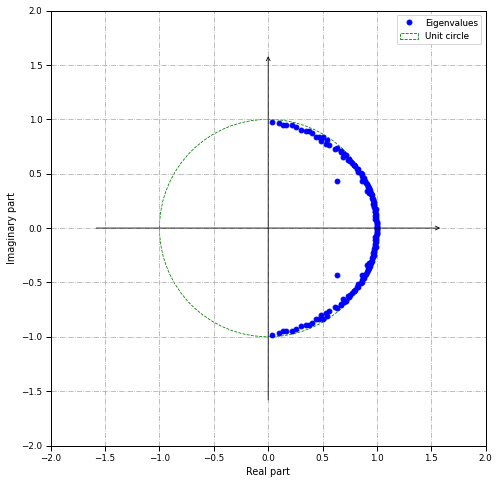

In [21]:
dmd.plot_eigs(show_axes=True, show_unit_circle=True)

In [22]:
# re-generate the HODMD time-lagged snapshots of Hankel matrix formulation
snaps = np.concatenate(
    [
        dmd._snapshots[:, i:dmd._snapshots.shape[1] - dmd.d + i + 1]
        for i in range(dmd.d)
    ],
    axis=0) * 1e6

# rescale the modes
modes = rescale_modes(snaps, dmd.atilde, dmd)

print(modes.shape)

(98, 153)


(153,)


<AxesSubplot:>

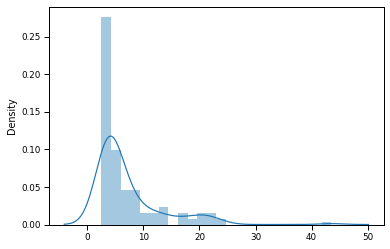

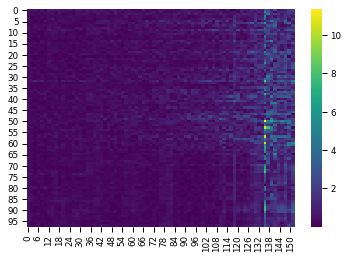

In [23]:
modepower = np.linalg.norm(modes, axis=0)
print(modepower.shape)
sns.distplot(np.linalg.norm(modes, axis=0))

plt.figure()
sns.heatmap(np.abs(modes), cmap='viridis')

In [24]:
# modepower = np.multiply(np.abs(dmd.amplitudes), np.power(np.linalg.norm(dmd.modes, ord=2, axis=0),2))#[sorted_inds]
# modes
modepower = np.linalg.norm(modes, ord=2, axis=0) **2

print(modepower.shape)

(153,)


In [25]:
growth_rates, freqs = compute_frequencies(dmd.eigs, 1/raw.info['sfreq'])

In [26]:
zero_freq_inds = np.argwhere(np.abs(freqs) != 0)
freqs = np.array(freqs)[zero_freq_inds]
modepower = modepower[zero_freq_inds]

[3.78661026] [[-1.08388284]]


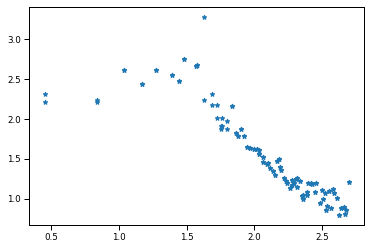

In [28]:
# linear fit
lm = LinearRegression()
lm.fit(np.log10(np.abs(freqs)).reshape(-1, 1), np.log10(modepower))
dmd_int, dmd_slope = lm.intercept_, lm.coef_

print(dmd_int, dmd_slope)

plt.plot(np.log10(np.abs(freqs)), np.log10(modepower), '*')

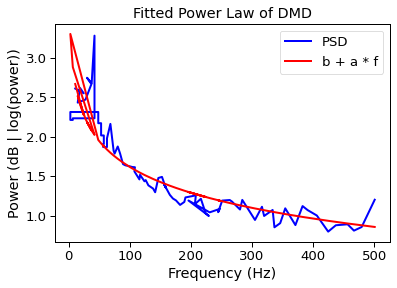

In [34]:
sns.set_context('paper', font_scale=1.5)
plt.figure()
plt.plot(np.abs(freqs), np.log10(modepower), '-b', lw=2, label='PSD')
plt.plot(np.abs(freqs), dmd_int + dmd_slope * np.log10(np.abs(freqs)), '-r', lw=2, label='b + a * f')
plt.title(f'Fitted Power Law of DMD')
ax = plt.gca()
ax.set(xlabel='Frequency (Hz)', 
       ylabel='Power (dB | log(power))')
ax.legend()

In [159]:
freqs = np.abs(freqs).squeeze()

modepower = modepower[np.argwhere(freqs < 100)].squeeze()
freqs = freqs[freqs < 100]

print(freqs.shape, modepower.shape)

(112,) (112,)


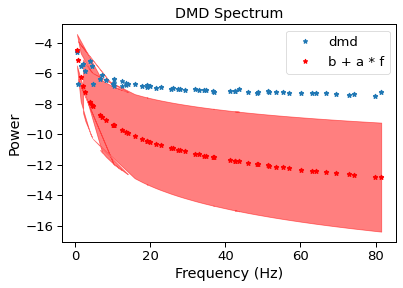

In [160]:
# make sure freqs are sorted
# sorted_inds = np.argsort(np.abs(freqs))
# freqs = np.array(freqs)[sorted_inds]

fig, ax = plt.subplots()
ax.plot(np.abs(freqs),
        np.log10(modepower) - dmd_int + np.mean(intercepts), '*',
       label='dmd')
ax.set(
    title='DMD Spectrum',
    xlabel='Frequency (Hz)',
    ylabel='Power'
)

# compute ymean and ystd based on power law fitting
ymean = np.mean(intercepts) + np.mean(slopes) * np.log10(np.abs(freqs))
ystd = np.std(intercepts) + np.std(slopes) * np.log10(np.abs(freqs))
ax.plot(np.abs(freqs), ymean,
       '*r', lw=2, label='b + a * f')
ax.fill_between(np.abs(freqs), ymean-3*ystd, ymean + 3*ystd, 
                alpha=0.5, color='red')
ax.legend()

Done


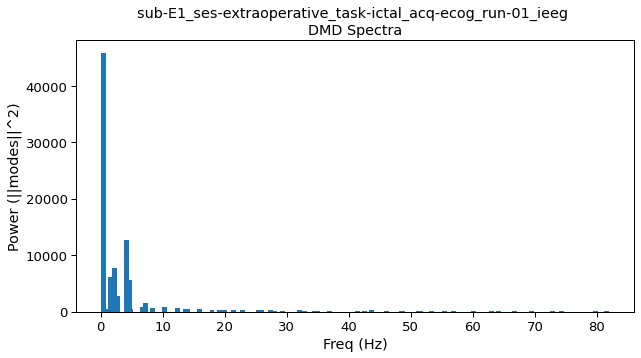

In [161]:
# growth_rates, freqs = compute_frequencies(dmd.eigs, 1/raw.info['sfreq'])

freqs = np.abs(freqs)
fig, ax = plt.subplots(figsize=(10, 5))
ax.bar(np.abs(freqs), np.abs(modepower),)
ax.set(
    xlabel='Freq (Hz)',
    ylabel='Power (||modes||^2)',
    title=f'{bids_path.basename} \nDMD Spectra',
)

print('Done')

In [46]:
freq_band_ranges = {
    'delta': [0, 4],
    'theta': [4, 8],
    'alpha': [8, 13],
    'beta': [13, 30],
    'gamma': [30, 90],
    'highgamma': [90, 1000]
}

freq_band_nums = {
    'delta': 1,
    'theta': 2,
    'alpha': 3,
    'beta': 4,
    'gamma': 5,
    'highgamma': 6
}

srtinds = np.argsort(np.abs(modepower))[::-1]
print(modepower.shape, freqs.shape)
freqbands = []
for freq in freqs:
    for band, bandrange in freq_band_ranges.items():
        if freq >= bandrange[0] and freq <= bandrange[1]:
            freqbands.append(band)
sorted_bands = np.array(freqbands)[srtinds]

# create dataframe
sorted_bands_df = pd.DataFrame(sorted_bands, columns=['bands'])
sorted_bands_df = sorted_bands_df.melt()
display(sorted_bands_df.head(3))

sorted_bands_df = sorted_bands_df.groupby('value').count().reset_index()
display(sorted_bands_df)

fig, ax = plt.subplots()
for idx, band in enumerate(sorted_bands):
    y = freq_band_nums[band]
    ax.plot(idx, y, '*', color=cm.hot(y))
ax.set_yticks(np.arange(1, 7))
ax.set_yticklabels(freq_band_nums.keys())
ax.set(title='Sorted Eigenvalue Relative Magnitude Against Frequency Bands',
      ylabel='Frequency Bands',
      xlabel='Sorted Contribution to System (highest -> lowest)')

(153,) (153,)


,variable,value
0,bands,gamma
1,bands,gamma
2,bands,gamma


,value,variable
0,alpha,2
1,beta,8
2,delta,3
3,gamma,30
4,highgamma,108
5,theta,2


[Text(0.5, 1.0, 'Sorted Eigenvalue Relative Magnitude Against Frequency Bands'),
 Text(0, 0.5, 'Frequency Bands'),
 Text(0.5, 0, 'Sorted Contribution to System (highest -> lowest)')]

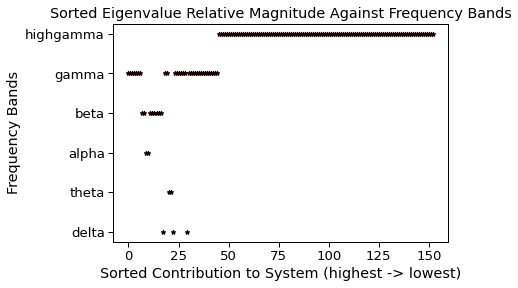

In [47]:

fig, ax = plt.subplots()
for idx, band in enumerate(sorted_bands):
    y = freq_band_nums[band]
    ax.plot(idx, y, '*', color=cm.hot(y))
ax.set_yticks(np.arange(1, 7))
ax.set_yticklabels(freq_band_nums.keys())
ax.set(title='Sorted Eigenvalue Relative Magnitude Against Frequency Bands',
      ylabel='Frequency Bands',
      xlabel='Sorted Contribution to System (highest -> lowest)')


[Text(0.5, 1.0, 'Sorted Eigenvalue Relative Magnitude Against Frequency Bands'),
 Text(0, 0.5, 'Frequency Bands'),
 Text(0.5, 0, 'Sorted Contribution to System (highest -> lowest)')]

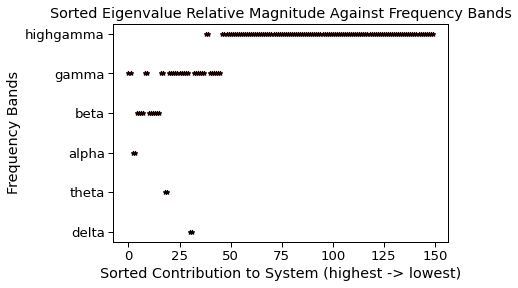

In [383]:
import matplotlib.cm as cm

fig, ax = plt.subplots()
for idx, band in enumerate(sorted_bands):
    y = freq_band_nums[band]
    ax.plot(idx, y, '*', color=cm.hot(y))
ax.set_yticks(np.arange(1, 7))
ax.set_yticklabels(freq_band_nums.keys())
ax.set(title='Sorted Eigenvalue Relative Magnitude Against Frequency Bands',
      ylabel='Frequency Bands',
      xlabel='Sorted Contribution to System (highest -> lowest)')

## Interictal Asleep

In [50]:
print(bids_path.copy().update(task=None).match())
bids_path.update(session='extraoperative', task='IED', run='01')
bids_path.update(session='extraoperative', task='ExtraoperativeInterictalSleepD1', run='01')

[BIDSPath(
root: /Users/adam2392/OneDrive - Johns Hopkins/sickkids
datatype: ieeg
basename: sub-E1_ses-extraoperative_task-ExtraoperativeInterictalAwakeD1_acq-ecog_run-01_ieeg.vhdr), BIDSPath(
root: /Users/adam2392/OneDrive - Johns Hopkins/sickkids
datatype: ieeg
basename: sub-E1_ses-extraoperative_task-ExtraoperativeInterictalSleepD1_acq-ecog_run-01_ieeg.vhdr), BIDSPath(
root: /Users/adam2392/OneDrive - Johns Hopkins/sickkids
datatype: ieeg
basename: sub-E1_ses-extraoperative_task-ExtraoperativeSubclinicalMPOD5_acq-ecog_run-01_ieeg.vhdr), BIDSPath(
root: /Users/adam2392/OneDrive - Johns Hopkins/sickkids
datatype: ieeg
basename: sub-E1_ses-extraoperative_task-ExtraoperativeSubclinicalSzIPD4to5_acq-ecog_run-01_ieeg.vhdr), BIDSPath(
root: /Users/adam2392/OneDrive - Johns Hopkins/sickkids
datatype: ieeg
basename: sub-E1_ses-extraoperative_task-ExtraoperativeSz01_acq-ecog_run-01_ieeg.vhdr)]


BIDSPath(
root: /Users/adam2392/OneDrive - Johns Hopkins/sickkids
datatype: ieeg
basename: sub-E1_ses-extraoperative_task-ExtraoperativeInterictalSleepD1_acq-ecog_run-01_ieeg.vhdr)

In [51]:
raw = read_raw_bids(bids_path, verbose=False)
raw.drop_channels(raw.info['bads'])
raw.pick_types(seeg=True, ecog=True)
raw.load_data()
print(raw)

l_freq = 0.5
h_freq = 300
line_freq = raw.info['line_freq']
nyq_freq = raw.info['sfreq'] // 2
freqs = np.arange(line_freq, min(h_freq, nyq_freq), line_freq)
raw.filter(l_freq=l_freq, h_freq=h_freq)

print(f'Band pass filtering between {l_freq} and {h_freq}')
print(f'Notch filtering at {freqs}')

raw = raw.notch_filter(freqs, method='fir')

<ipython-input-51-97607197807d>:1: RuntimeWarning: Did not find any events.tsv associated with sub-E1_ses-extraoperative_task-ExtraoperativeInterictalSleepD1_acq-ecog_run-01.

The search_str was "/Users/adam2392/OneDrive - Johns Hopkins/sickkids/sub-E1/**/sub-E1_ses-extraoperative*events.tsv"
  raw = read_raw_bids(bids_path, verbose=False)
<ipython-input-51-97607197807d>:1: RuntimeWarning: There are channels without locations (n/a) that are not marked as bad: ['C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8', 'C9', 'C10', 'C11', 'C12', 'C13', 'C14', 'C16', 'C17', 'C18', 'C19', 'C20', 'C21', 'C22', 'C23', 'C24', 'C25', 'C26', 'C27', 'C28', 'C29', 'C30', 'C31', 'C32', 'C33', 'C34', 'C35', 'C36', 'C37', 'C38', 'C39', 'C40', 'C41', 'C42', 'C43', 'C44', 'C45', 'C46', 'C47', 'C48', 'C49', 'C50', 'C51', 'C52', 'C53', 'C54', 'C55', 'C56', 'C58', 'C59', 'C60', 'C61', 'C62', 'C63', 'C64', 'IPD1', 'IPD2', 'IPD3', 'IPD4', 'IPD5', 'IPD6', 'IAD1', 'IAD2', 'IAD3', 'IAD4', 'IAD5', 'IAD6', 'SAD1', 'SAD2'

<RawBrainVision | sub-E1_ses-extraoperative_task-ExtraoperativeInterictalSleepD1_acq-ecog_run-01_ieeg.eeg, 98 x 618112 (301.6 s), ~462.3 MB, data loaded>
Band pass filtering between 0.5 and 300
Notch filtering at [ 60 120 180 240]


In [52]:
print(raw)
raw.load_data()

<RawBrainVision | sub-E1_ses-extraoperative_task-ExtraoperativeInterictalSleepD1_acq-ecog_run-01_ieeg.eeg, 98 x 618112 (301.6 s), ~462.3 MB, data loaded>


<RawBrainVision | sub-E1_ses-extraoperative_task-ExtraoperativeInterictalSleepD1_acq-ecog_run-01_ieeg.eeg, 98 x 618112 (301.6 s), ~462.3 MB, data loaded>

In [54]:
d = 10
dmd = pydmd.HODMD(svd_rank=0, exact=True, opt=True, d=d)
X, t = raw.get_data(start=0, stop=2000, return_times=True)
dmd.fit(X)

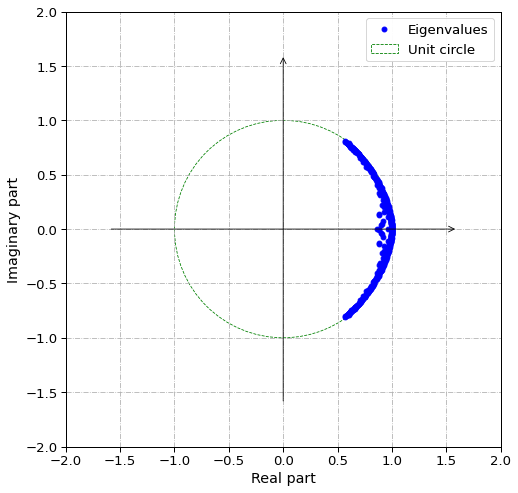

In [55]:
dmd.plot_eigs(show_axes=True, show_unit_circle=True)

In [58]:
# re-generate the HODMD time-lagged snapshots of Hankel matrix formulation
snaps = np.concatenate(
    [
        dmd._snapshots[:, i:dmd._snapshots.shape[1] - dmd.d + i + 1]
        for i in range(dmd.d)
    ],
    axis=0) * 1e6

# rescale the modes
modes = rescale_modes(snaps, dmd.atilde, dmd)

print(modes.shape)

(98, 441)


In [64]:
freqs = np.abs(dmd.frequency)
print(freqs.shape)
print(dmd.amplitudes.shape)

# modepower = np.multiply(np.abs(dmd.amplitudes), np.power(np.linalg.norm(dmd.modes, ord=2, axis=0),2))#[sorted_inds]
# modes
modepower = np.linalg.norm(modes, ord=2, axis=0)**2

print(modepower.shape)

(441,)
(441,)
(441,)


Done


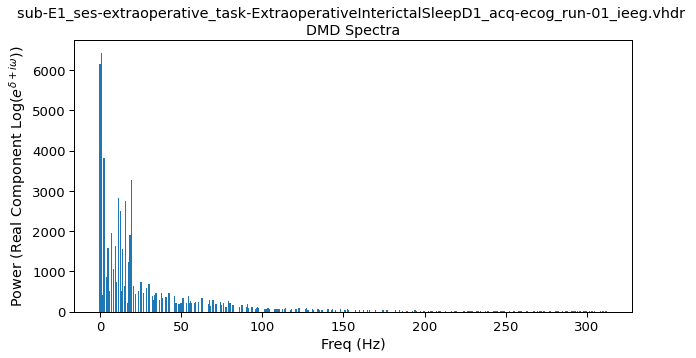

In [66]:
growth_rates, freqs = compute_frequencies(dmd.eigs, 1/raw.info['sfreq'])

freqs = np.abs(freqs)
fig, ax = plt.subplots(figsize=(10, 5))
ax.bar(freqs, np.abs(modepower),)
ax.set(
    xlabel='Freq (Hz)',
    ylabel='Power (Real Component Log($e^{\delta + i \omega}$))',
    title=f'{bids_path.basename} \nDMD Spectra',
)

print('Done')

(441,) (441,)


,variable,value
0,bands,delta
1,bands,delta
2,bands,delta


,value,variable
0,alpha,10
1,beta,38
2,delta,13
3,gamma,102
4,highgamma,272
5,theta,6


[Text(0.5, 1.0, 'Sorted Eigenvalue Relative Magnitude Against Frequency Bands'),
 Text(0, 0.5, 'Frequency Bands'),
 Text(0.5, 0, 'Sorted Contribution to System (highest -> lowest)')]

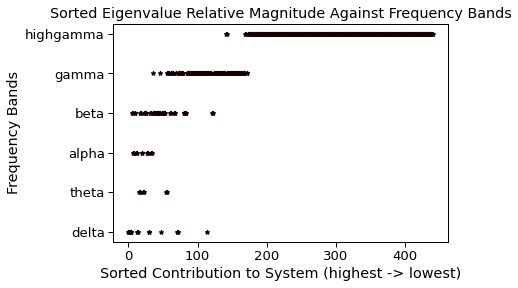

In [67]:
freq_band_ranges = {
    'delta': [0, 4],
    'theta': [4, 8],
    'alpha': [8, 13],
    'beta': [13, 30],
    'gamma': [30, 90],
    'highgamma': [90, 1000]
}

freq_band_nums = {
    'delta': 1,
    'theta': 2,
    'alpha': 3,
    'beta': 4,
    'gamma': 5,
    'highgamma': 6
}

srtinds = np.argsort(np.abs(modepower))[::-1]
print(modepower.shape, freqs.shape)
freqbands = []
for freq in freqs:
    for band, bandrange in freq_band_ranges.items():
        if freq >= bandrange[0] and freq <= bandrange[1]:
            freqbands.append(band)
sorted_bands = np.array(freqbands)[srtinds]

# create dataframe
sorted_bands_df = pd.DataFrame(sorted_bands, columns=['bands'])
sorted_bands_df = sorted_bands_df.melt()
display(sorted_bands_df.head(3))

sorted_bands_df = sorted_bands_df.groupby('value').count().reset_index()
display(sorted_bands_df)

fig, ax = plt.subplots()
for idx, band in enumerate(sorted_bands):
    y = freq_band_nums[band]
    ax.plot(idx, y, '*', color=cm.hot(y))
ax.set_yticks(np.arange(1, 7))
ax.set_yticklabels(freq_band_nums.keys())
ax.set(title='Sorted Eigenvalue Relative Magnitude Against Frequency Bands',
      ylabel='Frequency Bands',
      xlabel='Sorted Contribution to System (highest -> lowest)')

## Anesthetic

In [68]:
bids_path.update(session='preresection', task='pre')

BIDSPath(
root: /Users/adam2392/OneDrive - Johns Hopkins/sickkids
datatype: ieeg
basename: sub-E1_ses-preresection_task-pre_acq-ecog_run-01_ieeg.vhdr)

In [69]:
raw = read_raw_bids(bids_path, verbose=False)
raw.drop_channels(raw.info['bads'])
raw.pick_types(seeg=True, ecog=True)
raw.load_data()
print(raw)

l_freq = 0.5
h_freq = 300
line_freq = raw.info['line_freq']
nyq_freq = raw.info['sfreq'] // 2
freqs = np.arange(line_freq, min(h_freq, nyq_freq), line_freq)
raw.filter(l_freq=l_freq, h_freq=h_freq)

print(f'Band pass filtering between {l_freq} and {h_freq}')
print(f'Notch filtering at {freqs}')

raw = raw.notch_filter(freqs, method='fir')

<ipython-input-69-97607197807d>:1: RuntimeWarning: Did not find any events.tsv associated with sub-E1_ses-preresection_task-pre_acq-ecog_run-01.

The search_str was "/Users/adam2392/OneDrive - Johns Hopkins/sickkids/sub-E1/**/sub-E1_ses-preresection*events.tsv"
  raw = read_raw_bids(bids_path, verbose=False)
<ipython-input-69-97607197807d>:1: RuntimeWarning: There are channels without locations (n/a) that are not marked as bad: ['C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8', 'C9', 'C10', 'C11', 'C12', 'C13', 'C14', 'C16', 'C17', 'C18', 'C19', 'C20', 'C21', 'C22', 'C23', 'C24', 'C25', 'C26', 'C27', 'C28', 'C29', 'C30', 'C31', 'C32', 'C33', 'C34', 'C35', 'C36', 'C37', 'C38', 'C39', 'C40', 'C41', 'C42', 'C43', 'C44', 'C45', 'C46', 'C47', 'C48', 'C49', 'C50', 'C51', 'C52', 'C53', 'C54', 'C55', 'C56', 'C58', 'C59', 'C60', 'C61', 'C62', 'C63', 'C64', 'IPD1', 'IPD2', 'IPD3', 'IPD4', 'IPD5', 'IPD6', 'IAD1', 'IAD2', 'IAD3', 'IAD4', 'IAD5', 'IAD6', 'SAD1', 'SAD2', 'SAD3', 'SAD4', 'SAD5', 'SAD6'

<RawBrainVision | sub-E1_ses-preresection_task-pre_acq-ecog_run-01_ieeg.eeg, 98 x 656000 (320.1 s), ~490.6 MB, data loaded>
Band pass filtering between 0.5 and 300
Notch filtering at [ 60 120 180 240]


In [70]:
print(raw)
raw.load_data()

<RawBrainVision | sub-E1_ses-preresection_task-pre_acq-ecog_run-01_ieeg.eeg, 98 x 656000 (320.1 s), ~490.6 MB, data loaded>


<RawBrainVision | sub-E1_ses-preresection_task-pre_acq-ecog_run-01_ieeg.eeg, 98 x 656000 (320.1 s), ~490.6 MB, data loaded>

In [71]:
d = 10
dmd = pydmd.HODMD(svd_rank=0, exact=True, opt=True, d=d)
X, t = raw.get_data(start=0, stop=2000, return_times=True)
dmd.fit(X)

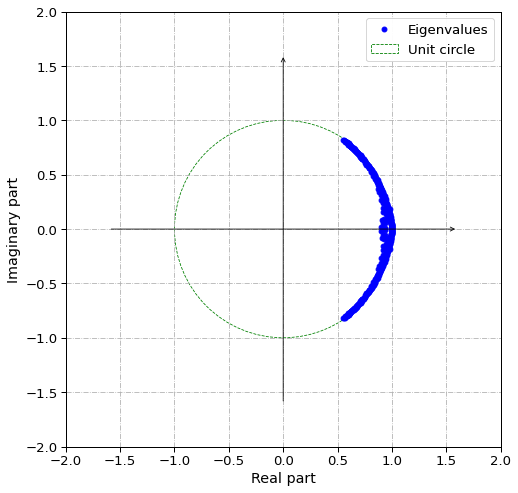

In [72]:
dmd.plot_eigs(show_axes=True, show_unit_circle=True)

In [73]:
# re-generate the HODMD time-lagged snapshots of Hankel matrix formulation
snaps = np.concatenate(
    [
        dmd._snapshots[:, i:dmd._snapshots.shape[1] - dmd.d + i + 1]
        for i in range(dmd.d)
    ],
    axis=0) * 1e6

# rescale the modes
modes = rescale_modes(snaps, dmd.atilde, dmd)

print(modes.shape)

(98, 438)


In [74]:
print(dmd.amplitudes.shape)

# modepower = np.multiply(np.abs(dmd.amplitudes), np.power(np.linalg.norm(dmd.modes, ord=2, axis=0),2))#[sorted_inds]
# modes
modepower = np.linalg.norm(modes, ord=2, axis=0)**2

print(modepower.shape)

(438,)
(438,)


Done


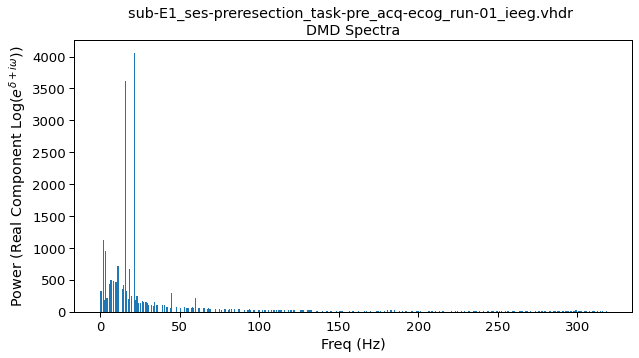

In [75]:
growth_rates, freqs = compute_frequencies(dmd.eigs, 1/raw.info['sfreq'])

freqs = np.abs(freqs)
fig, ax = plt.subplots(figsize=(10, 5))
ax.bar(freqs, np.abs(modepower),)
ax.set(
    xlabel='Freq (Hz)',
    ylabel='Power (Real Component Log($e^{\delta + i \omega}$))',
    title=f'{bids_path.basename} \nDMD Spectra',
)

print('Done')

(438,) (438,)


,variable,value
0,bands,beta
1,bands,beta
2,bands,beta


,value,variable
0,alpha,10
1,beta,40
2,delta,12
3,gamma,88
4,highgamma,280
5,theta,8


[Text(0.5, 1.0, 'Sorted Eigenvalue Relative Magnitude Against Frequency Bands'),
 Text(0, 0.5, 'Frequency Bands'),
 Text(0.5, 0, 'Sorted Contribution to System (highest -> lowest)')]

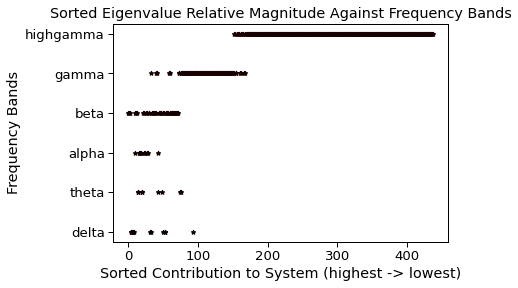

In [76]:
freq_band_ranges = {
    'delta': [0, 4],
    'theta': [4, 8],
    'alpha': [8, 13],
    'beta': [13, 30],
    'gamma': [30, 90],
    'highgamma': [90, 1000]
}

freq_band_nums = {
    'delta': 1,
    'theta': 2,
    'alpha': 3,
    'beta': 4,
    'gamma': 5,
    'highgamma': 6
}

srtinds = np.argsort(np.abs(modepower))[::-1]
print(modepower.shape, freqs.shape)
freqbands = []
for freq in freqs:
    for band, bandrange in freq_band_ranges.items():
        if freq >= bandrange[0] and freq <= bandrange[1]:
            freqbands.append(band)
sorted_bands = np.array(freqbands)[srtinds]

# create dataframe
sorted_bands_df = pd.DataFrame(sorted_bands, columns=['bands'])
sorted_bands_df = sorted_bands_df.melt()
display(sorted_bands_df.head(3))

sorted_bands_df = sorted_bands_df.groupby('value').count().reset_index()
display(sorted_bands_df)

fig, ax = plt.subplots()
for idx, band in enumerate(sorted_bands):
    y = freq_band_nums[band]
    ax.plot(idx, y, '*', color=cm.hot(y))
ax.set_yticks(np.arange(1, 7))
ax.set_yticklabels(freq_band_nums.keys())
ax.set(title='Sorted Eigenvalue Relative Magnitude Against Frequency Bands',
      ylabel='Frequency Bands',
      xlabel='Sorted Contribution to System (highest -> lowest)')

## During Intraresection or Postresection

In [86]:
bids_path = bids_path.copy().update(session='intraresection', task='Szmidresection')

bids_path = bids_path.copy().update(session='postresection', task='post')
# bids_path = bids_path.copy().update(session='extraoperative', task='ExtraoperativeSz01')

# bids_path = bids_path.copy().update(session='extraoperative', task='Sz01')

In [87]:
raw = read_raw_bids(bids_path, verbose=False)
raw.drop_channels(raw.info['bads'])
raw.pick_types(seeg=True, ecog=True)
raw.load_data()
print(raw)

l_freq = 0.5
h_freq = 300
line_freq = raw.info['line_freq']
nyq_freq = raw.info['sfreq'] // 2
freqs = np.arange(line_freq, min(h_freq, nyq_freq), line_freq)
raw.filter(l_freq=l_freq, h_freq=h_freq)

print(f'Band pass filtering between {l_freq} and {h_freq}')
print(f'Notch filtering at {freqs}')

raw = raw.notch_filter(freqs, method='fir')

<ipython-input-87-97607197807d>:1: RuntimeWarning: Did not find any events.tsv associated with sub-E1_ses-postresection_task-post_acq-ecog_run-01.

The search_str was "/Users/adam2392/OneDrive - Johns Hopkins/sickkids/sub-E1/**/sub-E1_ses-postresection*events.tsv"
  raw = read_raw_bids(bids_path, verbose=False)
<ipython-input-87-97607197807d>:1: RuntimeWarning: There are channels without locations (n/a) that are not marked as bad: ['C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8', 'C9', 'C10', 'C11', 'C12', 'C13', 'C14', 'C16', 'C21', 'C22', 'C23', 'C24', 'C29', 'C30', 'C31', 'C32', 'C33', 'C35', 'C36', 'C37', 'C38', 'C39', 'C40', 'C41', 'C42', 'C43', 'C44', 'C45', 'C46', 'C47', 'C48', 'C49', 'C50', 'C52', 'C53', 'C54', 'C55', 'C56', 'C58', 'C60', 'C61', 'C62', 'C63', 'C64', 'C101', 'C102', 'C103', 'C104', 'C105', 'C106', 'C107', 'C108', 'C109', 'C110', 'C111', 'C112', 'C113', 'C114', 'C115', 'C116', 'C117', 'C118', 'C119', 'LFACE1', 'LFACE2', 'RFACE1', 'RFACE2']
  raw = read_raw_bids(bi

<RawBrainVision | sub-E1_ses-postresection_task-post_acq-ecog_run-01_ieeg.eeg, 51 x 62080 (30.3 s), ~24.3 MB, data loaded>
Band pass filtering between 0.5 and 300
Notch filtering at [ 60 120 180 240]


In [88]:
print(raw)
raw.load_data()

<RawBrainVision | sub-E1_ses-postresection_task-post_acq-ecog_run-01_ieeg.eeg, 51 x 62080 (30.3 s), ~24.3 MB, data loaded>


<RawBrainVision | sub-E1_ses-postresection_task-post_acq-ecog_run-01_ieeg.eeg, 51 x 62080 (30.3 s), ~24.3 MB, data loaded>

In [94]:
d = 10
dmd = pydmd.HODMD(svd_rank=0, exact=True, opt=True, d=d)
X, t = raw.get_data(start=0, stop=2000, return_times=True)
dmd.fit(X)

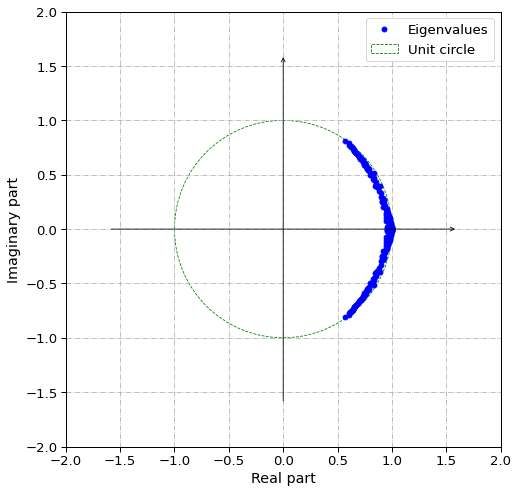

In [95]:
dmd.plot_eigs(show_axes=True, show_unit_circle=True)

In [96]:
# re-generate the HODMD time-lagged snapshots of Hankel matrix formulation
snaps = np.concatenate(
    [
        dmd._snapshots[:, i:dmd._snapshots.shape[1] - dmd.d + i + 1]
        for i in range(dmd.d)
    ],
    axis=0) * 1e6

# rescale the modes
modes = rescale_modes(snaps, dmd.atilde, dmd)

print(modes.shape)

(51, 222)


In [97]:
print(dmd.amplitudes.shape)

# modepower = np.multiply(np.abs(dmd.amplitudes), np.power(np.linalg.norm(dmd.modes, ord=2, axis=0),2))#[sorted_inds]
# modes
modepower = np.linalg.norm(modes, ord=2, axis=0)**2

print(modepower.shape)

(222,)
(222,)


Done


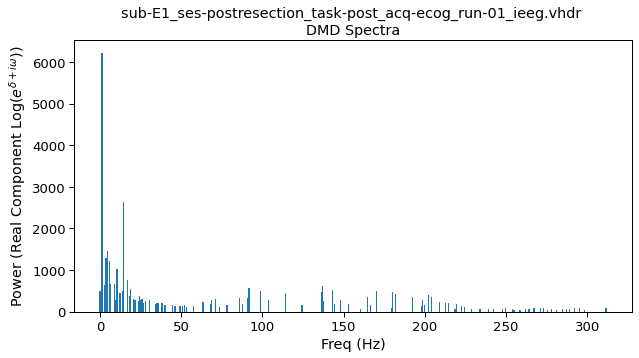

In [98]:
growth_rates, freqs = compute_frequencies(dmd.eigs, 1/raw.info['sfreq'])

freqs = np.abs(freqs)
fig, ax = plt.subplots(figsize=(10, 5))
ax.bar(freqs, np.abs(modepower),)
ax.set(
    xlabel='Freq (Hz)',
    ylabel='Power (Real Component Log($e^{\delta + i \omega}$))',
    title=f'{bids_path.basename} \nDMD Spectra',
)

print('Done')

(222,) (222,)


,variable,value
0,bands,delta
1,bands,delta
2,bands,beta


,value,variable
0,alpha,10
1,beta,26
2,delta,10
3,gamma,48
4,highgamma,120
5,theta,8


[Text(0.5, 1.0, 'Sorted Eigenvalue Relative Magnitude Against Frequency Bands'),
 Text(0, 0.5, 'Frequency Bands'),
 Text(0.5, 0, 'Sorted Contribution to System (highest -> lowest)')]

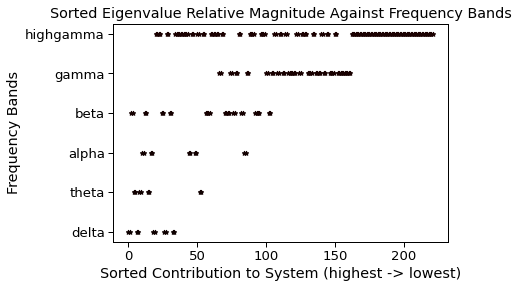

In [99]:
freq_band_ranges = {
    'delta': [0, 4],
    'theta': [4, 8],
    'alpha': [8, 13],
    'beta': [13, 30],
    'gamma': [30, 90],
    'highgamma': [90, 1000]
}

freq_band_nums = {
    'delta': 1,
    'theta': 2,
    'alpha': 3,
    'beta': 4,
    'gamma': 5,
    'highgamma': 6
}

srtinds = np.argsort(np.abs(modepower))[::-1]
print(modepower.shape, freqs.shape)
freqbands = []
for freq in freqs:
    for band, bandrange in freq_band_ranges.items():
        if freq >= bandrange[0] and freq <= bandrange[1]:
            freqbands.append(band)
sorted_bands = np.array(freqbands)[srtinds]

# create dataframe
sorted_bands_df = pd.DataFrame(sorted_bands, columns=['bands'])
sorted_bands_df = sorted_bands_df.melt()
display(sorted_bands_df.head(3))

sorted_bands_df = sorted_bands_df.groupby('value').count().reset_index()
display(sorted_bands_df)

fig, ax = plt.subplots()
for idx, band in enumerate(sorted_bands):
    y = freq_band_nums[band]
    ax.plot(idx, y, '*', color=cm.hot(y))
ax.set_yticks(np.arange(1, 7))
ax.set_yticklabels(freq_band_nums.keys())
ax.set(title='Sorted Eigenvalue Relative Magnitude Against Frequency Bands',
      ylabel='Frequency Bands',
      xlabel='Sorted Contribution to System (highest -> lowest)')

## DMD Reconstructions

(98, 500)
(98,)


[Text(0.5, 1.0, 'Mean squared error over all channels \nextraoperative, ExtraoperativeInterictalAwakeD1'),
 Text(0.5, 0, 'MSE'),
 Text(0, 0.5, 'Count')]

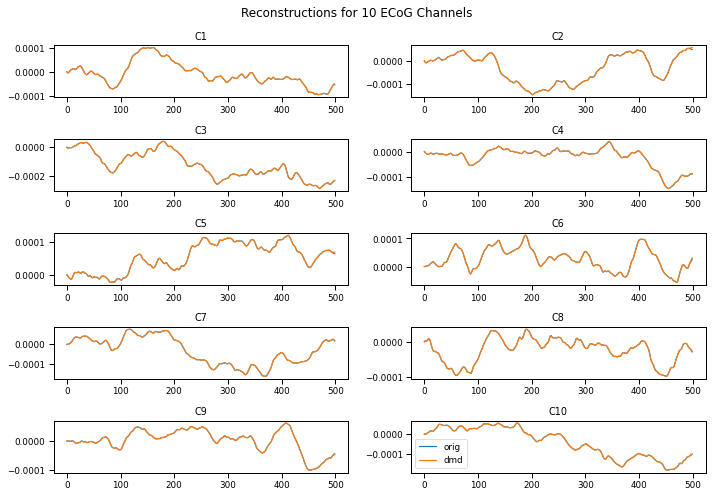

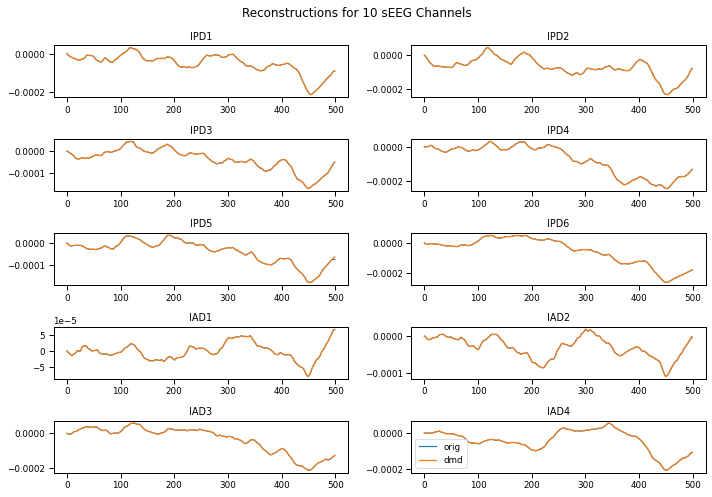

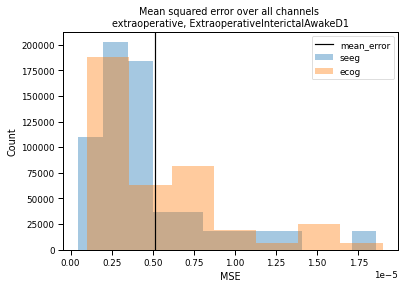

In [188]:
print(dmd.reconstructed_data.shape)
fig, axs = plt.subplots(5, 2, figsize=(10, 7))
axs = axs.flat
for idx, chdx in enumerate(mne.pick_types(raw.info, ecog=True)): 
    if idx >= len(axs):
        break
    ax = axs[idx]
    ax.plot(X[idx, :], label='orig')
    ax.plot(dmd.reconstructed_data[idx, ...].real, label='dmd')
    ax.set(title=raw.ch_names[idx])
ax.legend()
fig.suptitle('Reconstructions for 10 ECoG Channels')
fig.tight_layout()

fig, axs = plt.subplots(5, 2, figsize=(10, 7))
axs = axs.flat
for idx, chdx in enumerate(mne.pick_types(raw.info, seeg=True)): 
    if idx >= len(axs):
        break
    ax = axs[idx]
    ax.plot(X[chdx, :], label='orig')
    ax.plot(dmd.reconstructed_data[chdx, ...].real, label='dmd')
    ax.set(title=raw.ch_names[chdx])
ax.legend()
fig.suptitle('Reconstructions for 10 sEEG Channels')
fig.tight_layout()

# plot errors per channel
errors = np.linalg.norm(X - dmd.reconstructed_data.real, axis=1)
print(errors.shape)

seeg_inds = mne.pick_types(raw.info, seeg=True)
ecog_inds = mne.pick_types(raw.info, ecog=True)
fig, ax = plt.subplots()
sns.distplot(errors[seeg_inds], ax=ax, label='seeg')
sns.distplot(errors[ecog_inds], ax=ax, label='ecog')
ax.axvline(np.mean(errors), color='black', label='mean_error')
# ax.axvline(np.mean(errors[seeg_inds]), label='seeg-mean')
# ax.axvline(np.mean(errors[ecog_inds]), label='ecog-mean')
ax.legend()
ax.set(title=f'Mean squared error over all channels \n{bids_path.session}, {bids_path.task}',
      xlabel='MSE',
       ylabel='Count',
      )

# Fragility on Concatenated Raw

In [74]:
raw_copy = raw.copy().set_eeg_reference('average')
X1 = raw.get_data(start=0, stop=500)
X2, t = raw_copy.get_data(start=0, stop=500, return_times=True)
print(X1.shape, X2.shape)
X = np.concatenate((X1, X2), axis=0)
print(X.shape)

print(np.linalg.cond(X1))
print(np.linalg.cond(X2))
print(np.linalg.cond(X))

(98, 500) (98, 500)
(196, 500)
2578.820333510419
1.148518081935761e+16
6.548630180954103e+18


In [40]:
raw_copy = raw.set_eeg_reference([])
d = 5

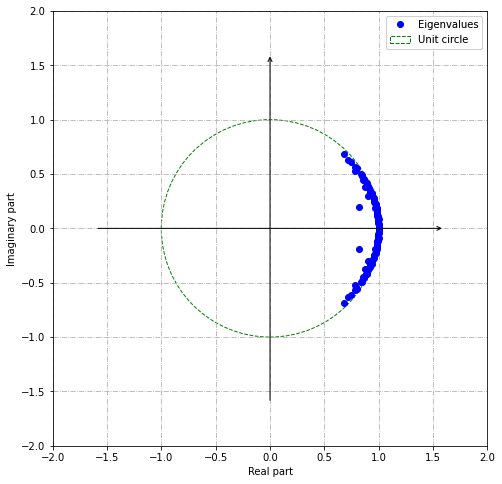

(1.0060915223545195+0.08817815131979759j)


In [75]:
dmd = pydmd.HODMD(svd_rank=len(raw.ch_names), exact=True, opt=True, d=d)
X, t = raw_copy.get_data(start=0, stop=500, return_times=True)
dmd.fit(X)
dmd.plot_eigs(show_axes=True, show_unit_circle=True)

print(dmd.eigs.max())

# DMD and Fragility on Reconstructed Low-Rank Data

In [31]:
mvarmodel = MvarModel(order=1)
adjmat_list = mvarmodel.fit(dmd.reconstructed_data)

In [33]:
pertmodel = MinNormPerturbModel(radius=1.5, perturb_type='C')
min_norms = pertmodel.fit(adjmat_list)

In [35]:
print(np.linalg.cond(dmd.reconstructed_data))
print(np.linalg.cond(X))
print(np.linalg.cond(dmd._snapshots))

129900958.52294162
841.547248135805
841.547248135805


In [41]:
snapshots = X
snaps = np.concatenate(
    [
        snapshots[:, i:snapshots.shape[1] - d + i + 1]
        for i in range(d)
    ],
    axis=0)
print(snaps.shape)

snapshot_A = snaps[:, :-1]  # x(t)
snapshot_B = snaps[:, 1:]  # x(t+1)

(420, 496)


In [45]:
U, S, V = np.linalg.svd(snapshot_A, full_matrices=False)
U = U[:, :len(raw.ch_names)]
print(U.shape, S.shape, V.shape)

(420, 84) (420,) (420, 495)


(84, 84)
(420, 420)


<AxesSubplot:>

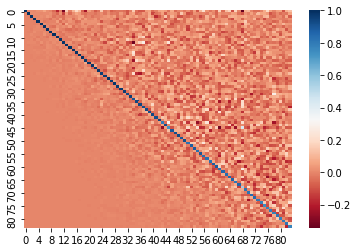

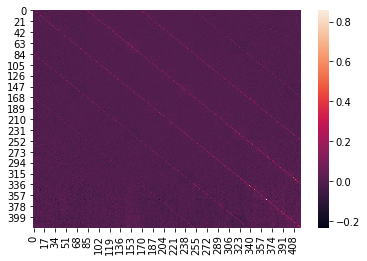

In [53]:
print(dmd.atilde.shape)
sns.heatmap(dmd.atilde, cmap='RdBu')

# A = U.dot(dmd.atilde).dot(U.T.conj())
# print(A.shape)

# plt.figure()
# sns.heatmap(A)

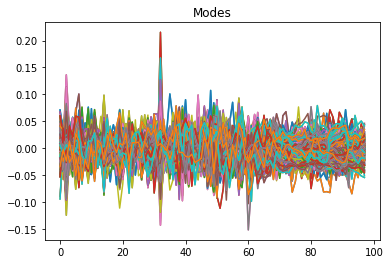

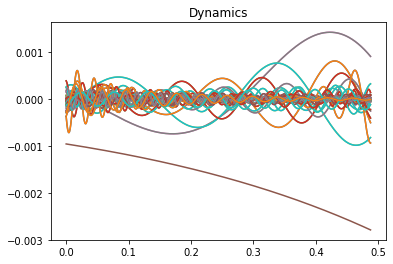

In [95]:
for idx, mode in enumerate(dmd.modes.T):
    plt.plot(np.arange(len(raw.ch_names)), mode.real)
    plt.title('Modes')
plt.show()

for dynamic in dmd.dynamics:
    plt.plot(t, dynamic.real)
    plt.title('Dynamics')
plt.show()

(98, 392)


<AxesSubplot:>

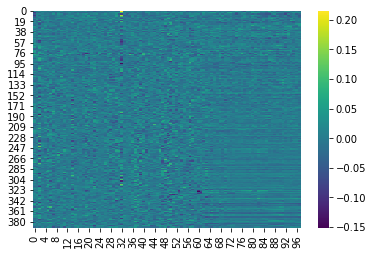

In [96]:
print(dmd.modes.shape)
sns.heatmap(dmd.modes.real.T, cmap='viridis')

(98, 1000)
(98,)


/Users/adam2392/Documents/sickkids/.venv/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


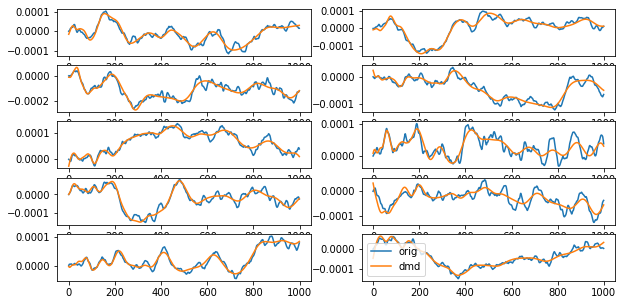

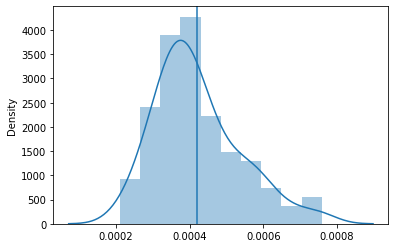

In [108]:
print(dmd.reconstructed_data.shape)
fig, axs = plt.subplots(5, 2, figsize=(10, 5))
axs = axs.flat
for idx in range(10): #len(raw.ch_names)):
    ax = axs[idx]
    ax.plot(X[idx, ...], label='orig')
    ax.plot(dmd.reconstructed_data[idx, ...].real, label='dmd')
#     break 
ax.legend()

# plot errors per channel
errors = np.linalg.norm(X - dmd.reconstructed_data.real, axis=1)
print(errors.shape)
fig, ax = plt.subplots()
sns.distplot(errors, ax=ax)
ax.axvline(np.mean(errors))

In [25]:
pmodes = dmd.partial_modes(level=1)
print(pmodes.shape)
fig = plt.plot(np.arange(len(raw.ch_names)), pmodes.real)


AttributeError: 'HODMD' object has no attribute 'partial_modes'

# DMD Spectrum Over Time

Now, that we have explored how DMD can accurately reconstruct iEEG data over a short window of time, and extract relevant modes with a corresponding frequency, we can summarize the contributing frequency bands over time.

We can run this over the extraoperative, anesthetic pre-resection and then to post-resection.

In [9]:
from eztrack.utils import _compute_samplepoints

In [53]:
bids_path.update(session='extraoperative', task='ictal')

BIDSPath(
root: /Users/adam2392/OneDrive - Johns Hopkins/sickkids
datatype: ieeg
basename: sub-E1_ses-extraoperative_task-ictal_acq-ecog_run-01_ieeg)

In [54]:
raw = read_raw_bids(bids_path, verbose=False)
raw.drop_channels(raw.info['bads'])
raw.pick_types(seeg=True, ecog=True)
raw.load_data()
print(raw)

l_freq = 0.5
h_freq = 500
line_freq = raw.info['line_freq']
nyq_freq = raw.info['sfreq'] // 2
freqs = np.arange(line_freq, min(h_freq, nyq_freq), line_freq)
raw.filter(l_freq=l_freq, h_freq=h_freq)

print(f'Band pass filtering between {l_freq} and {h_freq}')
print(f'Notch filtering at {freqs}')

raw = raw.notch_filter(freqs, method='fir')

<ipython-input-54-7e229e121881>:1: RuntimeWarning: Did not find any events.tsv associated with sub-E1_ses-extraoperative_task-ictal_acq-ecog_run-01.

The search_str was "/Users/adam2392/OneDrive - Johns Hopkins/sickkids/sub-E1/**/sub-E1_ses-extraoperative*events.tsv"
  raw = read_raw_bids(bids_path, verbose=False)
<ipython-input-54-7e229e121881>:1: RuntimeWarning: There are channels without locations (n/a) that are not marked as bad: ['C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8', 'C9', 'C10', 'C11', 'C12', 'C13', 'C14', 'C16', 'C17', 'C18', 'C19', 'C20', 'C21', 'C22', 'C23', 'C24', 'C25', 'C26', 'C27', 'C28', 'C29', 'C30', 'C31', 'C32', 'C33', 'C34', 'C35', 'C36', 'C37', 'C38', 'C39', 'C40', 'C41', 'C42', 'C43', 'C44', 'C45', 'C46', 'C47', 'C48', 'C49', 'C50', 'C51', 'C52', 'C53', 'C54', 'C55', 'C56', 'C58', 'C59', 'C60', 'C61', 'C62', 'C63', 'C64', 'IPD1', 'IPD2', 'IPD3', 'IPD4', 'IPD5', 'IPD6', 'IAD1', 'IAD2', 'IAD3', 'IAD4', 'IAD5', 'IAD6', 'SAD1', 'SAD2', 'SAD3', 'SAD4', 'SAD5', 

<RawBrainVision | sub-E1_ses-extraoperative_task-ictal_acq-ecog_run-01_ieeg.eeg, 98 x 343040 (167.4 s), ~256.6 MB, data loaded>
Band pass filtering between 0.5 and 500
Notch filtering at [ 60 120 180 240 300 360 420 480]


In [55]:
samplepoints = _compute_samplepoints(
    winsamps=2000, stepsamps=1000, numtimepoints=len(raw))
print(samplepoints.shape)

(342, 2)


In [56]:
# initialize DMD class
d = 10
dmd = pydmd.HODMD(svd_rank=125, exact=True, opt=True, d=d)

In [57]:
modes_list = []
freqs_list = []

# perform dmd over each window
for start, stop in samplepoints:
    # get data matrix
    X = raw.get_data(start=start, stop=stop)
    
    # run dmd
    dmd.fit(X)
    
    # re-scale modes based on singular values
    # re-generate the HODMD time-lagged snapshots of Hankel matrix formulation
    snaps = np.concatenate(
        [
            dmd._snapshots[:, i:dmd._snapshots.shape[1] - dmd.d + i + 1]
            for i in range(dmd.d)
        ],
        axis=0)

    # rescale the modes
    modes = rescale_modes(snaps, dmd.atilde, dmd)

    # store modes
    modes_list.append(modes)
    
    growth_rates, freqs = compute_frequencies(dmd.eigs, 1/raw.info['sfreq'])
    freqs = np.abs(freqs)
    
    # store frequencies
    freqs_list.append(freqs)

In [58]:
print(dmd.eigs.shape)

(125,)


In [59]:
fname = bids_path.update(extension=None).basename
fname = fname + '.npz'

In [60]:
np.savez_compressed(fname, modes=modes_list, freqs=freqs_list, 
                    ch_names=raw.ch_names, 
                    winsize=2000, stepsize=1000)

In [61]:
# re-open
with np.load(fname) as data_dict:
    data_dict = dict(data_dict)
    print(data_dict.keys())
    modes_list = data_dict['modes']
    freqs_list = data_dict['freqs']
    winsize = data_dict['winsize']
    stepsize = data_dict['stepsize']
    ch_names = data_dict['ch_names']

dict_keys(['modes', 'freqs', 'ch_names', 'winsize', 'stepsize'])


In [63]:
freq_band_ranges = {
    'delta': [0, 4],
    'theta': [4, 8],
    'alpha': [8, 13],
    'beta': [13, 30],
    'gamma': [30, 90],
    'highgamma': [90, 1000]
}

freq_band_nums = {
    'delta': 1,
    'theta': 2,
    'alpha': 3,
    'beta': 4,
    'gamma': 5,
    'highgamma': 6
}

In [168]:
bids_path.update(session='extraoperative', task='ictal')
bids_path.update(session='preresection', task='pre')
bids_path.update(session='postresection', task='post')

BIDSPath(
root: /Users/adam2392/OneDrive - Johns Hopkins/sickkids
datatype: ieeg
basename: sub-E1_ses-postresection_task-post_acq-ecog_run-01_ieeg)

In [169]:
fname = bids_path.update(extension=None).basename
fname = fname + '.npz'

In [170]:
# re-open
with np.load(fname) as data_dict:
    data_dict = dict(data_dict)
    print(data_dict.keys())
    modes_list = data_dict['modes']
    freqs_list = data_dict['freqs']
    winsize = data_dict['winsize']
    stepsize = data_dict['stepsize']
    ch_names = data_dict['ch_names']

dict_keys(['modes', 'freqs', 'ch_names', 'winsize', 'stepsize'])


/Users/adam2392/Documents/sickkids/.venv/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/adam2392/Documents/sickkids/.venv/lib/python3.7/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


[Text(0.5, 1.0, 'Sorted Eigenvalue Relative Magnitude Against Frequency Bands'),
 Text(0, 0.5, 'Frequency Bands'),
 Text(0.5, 0, 'Sorted Contribution to System (highest -> lowest)')]

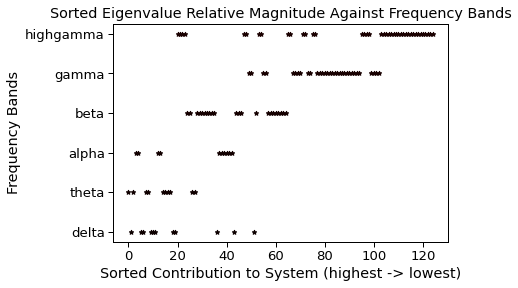

In [171]:
bandranks_map = collections.defaultdict(list)

# loop over set of modes and generate the ranked frequency bands 
# and compute a time-varying rank map
for iwin in range(modes_list.shape[0]):
    freqs = np.abs(freqs_list[iwin, ...])
    modes = modes_list[iwin, ...]
    
    # compute the power of the modes
    modepower = np.linalg.norm(modes, ord=2, axis=0)**2

    srtinds = np.argsort(np.abs(modepower))[::-1]
#     print(modepower.shape, freqs.shape)
    freqbands = []
    for freq in freqs:
        for band, bandrange in freq_band_ranges.items():
            if freq >= bandrange[0] and freq <= bandrange[1]:
                freqbands.append(band)
    sorted_bands = np.array(freqbands)[srtinds]

    for band in np.unique(sorted_bands):
        band_ranks = np.argwhere(sorted_bands[:10] == band)
        bandranks_map[band].append(np.mean(band_ranks))

# create dataframe of ranked counts
sorted_bands_df = pd.DataFrame(sorted_bands, columns=['bands'])
sorted_bands_df = sorted_bands_df.melt()
sorted_bands_df = sorted_bands_df.groupby('value').count().reset_index()
#     display(sorted_bands_df)

fig, ax = plt.subplots()
for idx, band in enumerate(sorted_bands):
    y = freq_band_nums[band]
    ax.plot(idx, y, '*', color=cm.hot(y))
ax.set_yticks(np.arange(1, 7))
ax.set_yticklabels(freq_band_nums.keys())
ax.set(title='Sorted Eigenvalue Relative Magnitude Against Frequency Bands',
      ylabel='Frequency Bands',
      xlabel='Sorted Contribution to System (highest -> lowest)')
#     break

In [172]:
bandranks_df = pd.DataFrame.from_dict(bandranks_map)
display(bandranks_df.head())

# bandranks_df = bandranks_df.melt(var_name='band', value_name='rank')

# display(bandranks_df.head())

,alpha,beta,delta,gamma,highgamma,theta
0,NaN,8.5,2.500000,NaN,NaN,6.5
1,9.0,NaN,4.428571,NaN,NaN,2.5
2,6.5,NaN,2.500000,NaN,NaN,5.5
3,NaN,NaN,3.000000,NaN,NaN,8.0
4,NaN,NaN,3.500000,NaN,NaN,6.0


<AxesSubplot:>

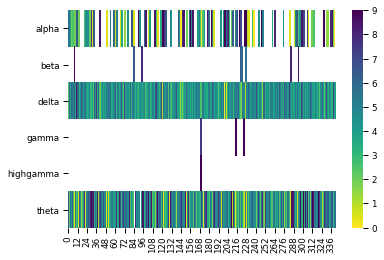

In [74]:
sns.heatmap(bandranks_df.T, cmap='viridis_r')

<AxesSubplot:>

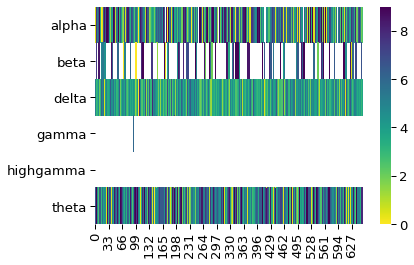

In [167]:
sns.heatmap(bandranks_df.T, cmap='viridis_r')

<AxesSubplot:>

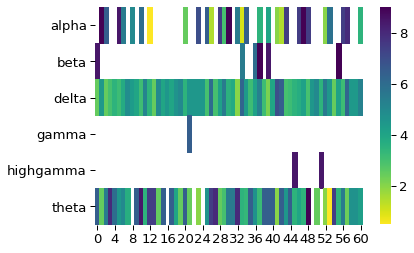

In [173]:
sns.heatmap(bandranks_df.T, cmap='viridis_r')

## DMD Significant Frequencies Over Time

Following Brunton paper, we determine the significant frequencies over time.

In [9]:
entities = [{'session': 'extraoperative', 'task': 'ictal'},
           {'session': 'preresection', 'task': 'pre'},
           {'session': 'postresection', 'task': 'post'}]

In [10]:
bids_path = BIDSPath(subject=subject, session=session,task=task,
                    acquisition=acquisition, run=run, suffix=datatype,
                    datatype=datatype, extension=extension,
                    root=root)

In [28]:
freq_band_ranges = {
    'delta': [0, 4],
    'theta': [4, 8],
    'alpha': [8, 13],
    'beta': [13, 30],
    'gamma': [30, 90],
    'highgamma': [90, 1000]
}

freq_band_nums = {
    'delta': 1,
    'theta': 2,
    'alpha': 3,
    'beta': 4,
    'gamma': 5,
    'highgamma': 6
}

In [11]:
from sklearn.utils import resample

In [16]:
# for x, y in resample([0,1], [3,4], n_samples=10):
print(resample(np.array([[0,1], [2,3]]), [3,4], n_samples=10)) 
print(resample([0,1], [3,4], n_samples=10))

[array([[0, 1],
       [2, 3],
       [2, 3],
       [2, 3],
       [0, 1],
       [0, 1],
       [0, 1],
       [2, 3],
       [2, 3],
       [2, 3]]), [3, 4, 4, 4, 3, 3, 3, 4, 4, 4]]
[[0, 0, 1, 1, 0, 1, 1, 0, 1, 0], [3, 3, 4, 4, 3, 4, 4, 3, 4, 3]]


In [26]:
for entity_kwargs in entities:
    bids_path.update(**entity_kwargs)
    
    fname = bids_path.update(extension=None).basename
    fname = fname + '.npz'
    
    # re-open
    with np.load(fname) as data_dict:
        data_dict = dict(data_dict)
        print(data_dict.keys())
        modes_list = data_dict['modes']
        freqs_list = data_dict['freqs']
        winsize = data_dict['winsize']
        stepsize = data_dict['stepsize']
        ch_names = data_dict['ch_names']
    
    print(modes_list.shape, freqs_list.shape)
    
    # compute significant frequencies over time
    for iwin in range(modes_list.shape[0]):
        dmd_modes = modes_list[iwin, ...]
        freqs = freqs_list[iwin, ...]
        
        # combine frequencies into bands and their modes
        band_indices = collections.defaultdict(list)
        for idx, freq in enumerate(freqs):
            for band, bandrange in freq_band_ranges.items():
                if freq >= bandrange[0] and freq <= bandrange[1]:
                    band_indices[band].append(idx)
        
        dmd_band_modes = []
        for band, indices in band_indices.items():
            
        
        
        # first compute a bootstrap of all samples
        dmd_int, intercepts, dmd_slope, slopes = compute_bootstrap_lr(dmd_modes, freqs, n_boot=100, random_state=None)

        # compute significant frequencies
        significant_freqs = compute_significant_freqs(dmd_modes, freqs, intercepts, slopes)
        
#         break
    break

dict_keys(['modes', 'freqs', 'ch_names', 'winsize', 'stepsize'])
(342, 98, 125) (342, 125)


Done


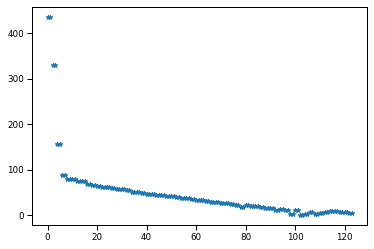

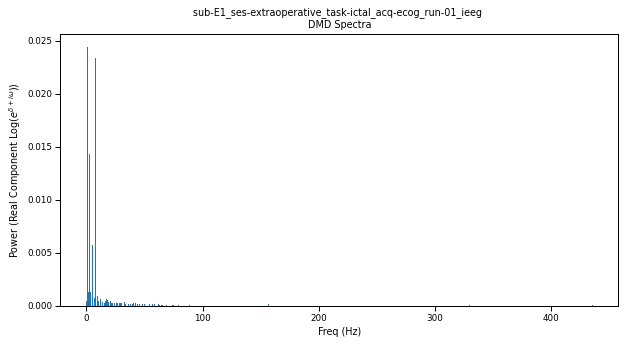

In [27]:
plt.plot(significant_freqs, '*')

fig, ax = plt.subplots(figsize=(10, 5))
modepower = np.linalg.norm(dmd_modes, ord=2, axis=0)**2
ax.bar(freqs, np.abs(modepower),)
ax.set(
    xlabel='Freq (Hz)',
    ylabel='Power (Real Component Log($e^{\delta + i \omega}$))',
    title=f'{bids_path.basename} \nDMD Spectra',
)

print('Done')